# Neural Networks for Classification
Here we will provide a code snippet that classifies a dataset of handwritten digits. The layout of the code will provide you with insights and by adapting it, you will solve a classification problem in the next exercise.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# here we just create a directory to store the dataset in
!mkdir mnist

First, we will download the dataset and put it into datastructures provided by Pytorch. The transforms used here are specific to the dataset and transform the images into a `torch.tensor`, which is the datastructure used by pytorch (for an in depth tutorial on how Pytorch works and can be used for custom problems you can visit the [tutorials](https://pytorch.org/tutorials/)). In a second step the data points are normalized, which is a usual preprocessing step when training neural networks.

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset_train = datasets.MNIST('./mnist/', train=True, download=True,
                   transform=transform)
dataset_test = datasets.MNIST('./mnist/', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=16)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=16)

1.3%

100.0%


Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist/MNIST\raw



100.0%


Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



21.9%


KeyboardInterrupt: 

Here you can have a look at the dataset to get a feeling on how it looks. The goal of the neural network is to use the image as an input and predict the number the image shows.

In [ ]:
plt.figure(figsize=(10,2),dpi=100)
for k,i in enumerate(np.random.randint(0, len(dataset_train),5)):
    plt.subplot(1,5,k+1)
    img, label = train_loader.dataset[i]
    img = img[0].numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Label = '+str(label))
    plt.axis('off')
plt.show()

For this prediction we will use a simple feedforward neural network architecture with one hidden layer and  ReLU-activation function. This activation function has excellent properties for training neural networks, since they solve the vanishing gradient problem and allow for deeper neural networks, but there are many different activation functions that can be used (see the [documentation](https://pytorch.org/docs/stable/nn.html) for a full list).
$$\mathrm{ReLU}(x) = max(0,x)$$
As output activation we use a logarithmic softmax, which can be seen as a mapping to the likelihoods of an image belonging to a certain class.

The architecture of our neural network consists of two fully connected layers defined in `__init__(self)`, which first map the $28*28=784$ pixels to 128 intermidiate values via matrix multiplication and an added bias term. This intermidiate vector is then mapped to a 10-dimensional ouput vector. The `forward(self, x)` method defines the forward pass of the neural network, where first the image is flattened into a vector, then the first fully connected layer is applied, then a ReLU activation, then the second fully connected layer and finally the logarithmic softmax function.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128) #The first parameter (aka in_parameters) means that the no. of parameters the current linear layers expects from the previous layer.
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

After defining our architecture, we need to perform the training of the parameters. This optimization procedure is in most instances based on a gradient descent variety. Since we have a lot of training samples here, computing the full gradient of the loss function with respect to each adaptable weight is very expensive. Instead we opt for an approximation of the gradient of a minibatch of samples (e.g. 16 samples). This gives an approximate gradient direction, which allows us to update our weights and minimize our loss function more efficiently. Below you find a loop over our training and testing dataset. Read through the code and try to understand what each statement means and what happens.

Run the loop below and train the model (this might take a while).

In [ ]:
# number of iterations
epochs = 10
# step width in gradient-based optimization
learning_rate = 0.0001
# initialize our model with random parameters
model = Net()
# choose an optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# choose a loss function
loss_function = F.nll_loss

# initialize lists for plotting
learning_curve_train = []
learning_curve_test = []

for epoch in range(1, epochs+1):
    
    # temporary variables to track model convergence
    loss_train = []
    loss_test = []
    correct = 0
    
    # Training Loop
    for data, target in train_loader:
        # set gradient to zero
        optimizer.zero_grad()
        # predict with current model
        output = model(data)
        # compute loss of predictions and target values
        loss = loss_function(output, target)
        # Backpropagation of errors gives gradients
        loss.backward()
        # Update weights with approximate gradient
        optimizer.step()
        # Store loss
        loss_train.append(loss.item())

    # Stop tracking gradients for evaluation phase
    with torch.no_grad():
        # Test Loop
        for data, target in test_loader:
            # predict with current model
            output = model(data)
            # compute loss
            loss = loss_function(output, target)
            # store loss
            loss_test.append(loss.item())
            # transform output into predicted class
            pred = output.argmax(dim=1, keepdim=True)
            # compare predictions and labels and store 
            # number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Store loss at each iteration for plotting
    learning_curve_train.append(np.mean(loss_train))
    learning_curve_test.append(np.mean(loss_test))
    
    # Print to Stdout
    print('Epoch: {}\tTrain loss: {:.4f}\tTest loss: {:.4f}\tTest Accuracy: {}/{} ({:.0f}%)'.format(
        epoch, learning_curve_train[-1], learning_curve_test[-1], 
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

We can check if the model generalizes by looking at the learning curve (loss of training and testing data at each iteration).

In [ ]:
plt.plot(np.arange(1, epochs+1), learning_curve_train, label='Train')
plt.plot(np.arange(1, epochs+1), learning_curve_test, label='Test')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend()

Now we can look at some of the predictions.

In [ ]:
plt.figure(figsize=(10,2),dpi=100)
for k,i in enumerate(np.random.randint(0, len(dataset_test),5)):
    plt.subplot(1,5,k+1)
    img, label = test_loader.dataset[i]
    pred = torch.argmax(model(img)).item()
    img = img[0].numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Prediction = '+str(pred))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('True = '+str(label))
plt.show()

# Classification of Stars (4P)
In this exercise we are going to adapt the previously provided code to work on a comparatively small dataset of star measurements from [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). From just four measurements (Temperature, Luminosity, Radius, Absolute magnitude), we will try to predict the star type (Browm Dwarf, Red Dwarf, White Dwarf, Main Sequence, Supergiant, Hypergiant) by using a Feedforward Neural Network architecture that was trained on 200 measurements. By determining hyperparameters we will optimize our model before we will test the generalization of the model to not seen instances.

First load the dataset in `star_data.csv` from Moodle with pandas and familiarize yourself with the dataset. Extract the data into Numpy-arrays called `x` and `y` for input (the four measurments) and output (the star type) data respectively and make sure that the each array has the correct datatype (`np.float32` for `x` and `np.longlong` for `y`. **Hint**: you can use `.to_numpy()` on pandas dataframes and `.astype()` on numpy arrays to change the datatype.

In [4]:
df = pd.read_csv("star_data.csv")
header = list(df.columns)
header

['Temperature (K)',
 'Luminosity(L/Lo)',
 'Radius(R/Ro)',
 'Absolute magnitude(Mv)',
 'Star type',
 'Star color',
 'Spectral Class']

In [5]:
y = df[header[4]].to_numpy(dtype=np.longlong)
x = df[df.columns[0:4]].to_numpy()
#x[:,1]  #getting columns

Write a function `rescale(x)` that min-max-scales each of your input-values to values between 0 and 1 (see [here](https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79) for an introduction). 
$$x_{i,rescaled}=\frac{x_i-x_{i,min}}{x_{i,max}-x_{i,min}}$$
Split the pairs of inputs and outputs into 200 training samples and 40 testing samples. Shuffle your data beforehand to prevent unexpected behaviour. 

In [6]:
max(x[:,0])  #40000
min(x[:,0])  #1939
x[:,1][0]

0.0024

In [7]:
def rescale(v,dataset):
    x_rescaled = (v - min(dataset)) / (max(dataset)-min(dataset))
    return x_rescaled

In [8]:
#rescale(x[:,2][0],x[:,2])

In [9]:
normalized = []
for i in range(4):
    for v in x[:,i]:
        normalized.append(rescale(v,x[:,i])) 
        
arr = np.array(normalized)
normalized_x = np.array(np.split(arr,4))
#normalized_x[0]
normalized_x_reshaped = normalized_x.T

In [10]:
# Use train_test_split to split the data
X_train, X_test, Y_train, Y_test = train_test_split(normalized_x_reshaped, y, test_size=40, train_size=200)

In [11]:
#idx = np.arange(len(normalized_x[0]))
#np.random.shuffle(indices)
#xx_train, yy_train = x[idx[:200]], y[idx[:200]]
#xx_test, yy_test = x[idx[200:]], y[idx[200:]]

In the introductory example on the MNIST dataset, the dataset was already provided in a clean datastructure which allowed for convenient usage. Now we have to create our own dataset. For this we will use the `Dataset` class provided in Pytorch. Complete the `__len__(self)` and `__getitem__(self, idx)` methods to return the number of samples in the dataset and the sample (input and label) with index `idx`. Print the number of training- and test-datasets and output some of the input and output pairs by calling 5 random indices.

In [12]:
from torch.utils.data import Dataset

class StarDataset(Dataset):
    def __init__(self, x, y,dtype=torch.float32):
        self.x = torch.from_numpy(x).to(dtype)
        self.y = torch.from_numpy(y).to(dtype)
        
    def __len__(self):
        return self.y.shape[0]  # return number of samples in dataset
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx].squeeze().long()  #return sample (input and label) with index
                                                          #.squeeze().long(), we put it in order to not have an array in y_output. (e.g. tensor(2))  
#StarDataset(X_train,Y_train).__getitem__(123)   #index can be up to 200.
dataset_train = StarDataset(X_train,Y_train,dtype=torch.float32)
dataset_test = StarDataset(X_test,Y_test,dtype=torch.float32)
print(len(dataset_train),len(dataset_test))
random_indices = np.random.randint(len(dataset_test), size=1)
print(dataset_train[random_indices])

200 40
(tensor([[1.6581e-01, 1.0890e-05, 3.0810e-04, 3.3202e-01]]), tensor(3))


Using the `DataLoader` class, create a dataloader of your training- and test-data. You can specify a batch size for loading the data. This batch size can be seen as a hyperparameter, which allows you to tune the convergence of your model.

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_train, batch_size=64) #The batch size is usually set between 64 and 256. The batch size does have an effect on the final test accuracy. One way to think about it is that smaller batches means that the number of parameter updates per epoch is greater
test_dataloader = DataLoader(dataset_test, batch_size=1)

Adapt the previously provided `Net` class to work with the new data. For this change the architecture to reflect the new input and output dimensions of your data. You can also add additional layers and change the sizes of the hidden layers to tune model performance. **Hint:** Remove the `flatten()` function, since our data is already a vector and not a matrix. You can change the width of your hidden layers by changing the `out_features`-parameter in a `nn.Linear`-layer and the `in_features` of the following `nn.Linear`-layer. 

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()   #inherit from nn.Module class
        self.fc1 = nn.Linear(4, 100) #The first parameter (aka in_parameters) means that the no. of parameters the current linear layers expects from the previous layer.
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 6) #We have 6 possible solutions (aka star types) !!!

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

Use the provide code of the training and evaluation loop to the train your new model on the star data. Tune the hyperparameters (i.e., number of hidden layers, width of hidden layers, used activation functions, learning rate, number of epochs, training batch size) to optimize the training procedure and model performance and describe the influence of the different hyperparameters on the model performance and the training procedure.

In [15]:
# number of iterations
epochs = 500
# step width in gradient-based optimization
learning_rate = 0.01
# initialize our model with random parameters
model = Net()
# choose an optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# choose a loss function
loss_function = F.nll_loss

# initialize lists for plotting
learning_curve_train = []
learning_curve_test = []

for epoch in range(1, epochs+1):
    
    # temporary variables to track model convergence
    loss_train = []
    loss_test = []
    correct = 0
    
    # Training Loop
    for data, target in train_dataloader:
        # set gradient to zero
        optimizer.zero_grad()
        # predict with current model
        output = model(data)
        # compute loss of predictions and target values
        loss = loss_function(output, target)
        # Backpropagation of errors gives gradients
        loss.backward()
        # Update weights with approximate gradient
        optimizer.step()
        # Store loss
        loss_train.append(loss.item())

    # Stop tracking gradients for evaluation phase
    with torch.no_grad():
        # Test Loop
        for data, target in test_dataloader:
            # predict with current model
            output = model(data)
            # compute loss
            loss = loss_function(output, target)
            # store loss
            loss_test.append(loss.item())
            # transform output into predicted class
            pred = output.argmax(dim=1, keepdim=True)
            # compare predictions and labels and store 
            # number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Store loss at each iteration for plotting
    learning_curve_train.append(np.mean(loss_train))
    learning_curve_test.append(np.mean(loss_test))
    
    # Print to Stdout
    print('Epoch: {}\tTrain loss: {:.4f}\tTest loss: {:.4f}\tTest Accuracy: {}/{} ({:.0f}%)'.format(
        epoch, learning_curve_train[-1], learning_curve_test[-1], 
        correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

Epoch: 1	Train loss: 1.7946	Test loss: 1.7954	Test Accuracy: 9/40 (22%)
Epoch: 2	Train loss: 1.7487	Test loss: 1.7685	Test Accuracy: 9/40 (22%)
Epoch: 3	Train loss: 1.7144	Test loss: 1.7296	Test Accuracy: 10/40 (25%)
Epoch: 4	Train loss: 1.6682	Test loss: 1.6774	Test Accuracy: 12/40 (30%)
Epoch: 5	Train loss: 1.6093	Test loss: 1.6065	Test Accuracy: 14/40 (35%)
Epoch: 6	Train loss: 1.5386	Test loss: 1.5266	Test Accuracy: 14/40 (35%)
Epoch: 7	Train loss: 1.4629	Test loss: 1.4503	Test Accuracy: 14/40 (35%)
Epoch: 8	Train loss: 1.3882	Test loss: 1.3845	Test Accuracy: 14/40 (35%)
Epoch: 9	Train loss: 1.3203	Test loss: 1.3271	Test Accuracy: 14/40 (35%)
Epoch: 10	Train loss: 1.2464	Test loss: 1.2773	Test Accuracy: 17/40 (42%)
Epoch: 11	Train loss: 1.1853	Test loss: 1.2142	Test Accuracy: 17/40 (42%)
Epoch: 12	Train loss: 1.1032	Test loss: 1.1759	Test Accuracy: 18/40 (45%)
Epoch: 13	Train loss: 1.0360	Test loss: 1.1261	Test Accuracy: 19/40 (48%)
Epoch: 14	Train loss: 0.9739	Test loss: 1.0626	Te

Visualize the learning curves of training and test data by plotting the loss at each epoch against the number of epochs.

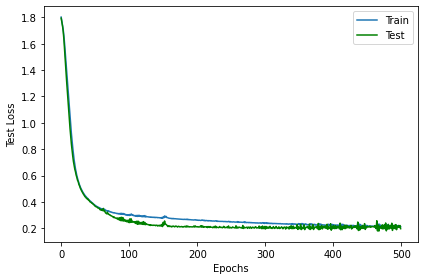

In [15]:
plt.plot(range(epochs),learning_curve_train, label='Train')
plt.plot(range(epochs),learning_curve_test,label='Test', color = "g")
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.tight_layout()

With your final model, predict the classes of the training and testing set one last time and visualize the corresponding confusion matrices. To do so, remember that the output of your model consists of a likelihood
for each class. Use the `argmax()` function to get the predicted class
label. To transform your torch tensors to python data you can use the
`.item()`-method. You can then use `sklearn.metrics.confusion_matrix()` to obtain
the confusion matrices, and `plt.imshow` to visualize them. 

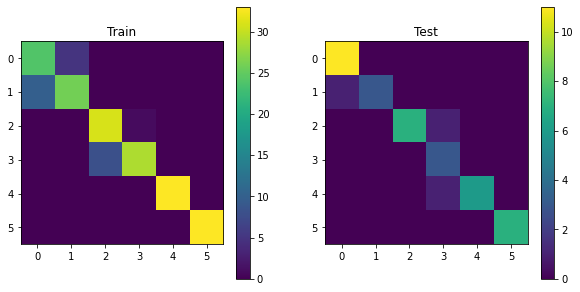

<Figure size 432x288 with 0 Axes>

In [43]:
from sklearn.metrics import confusion_matrix


train_dataloader = DataLoader(dataset_train, batch_size=1) #Batch size should be 1, if it is e.g. 64, then we have a tensor with 64 elements.
test_dataloader = DataLoader(dataset_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
true = []
pred = []
for data, target in train_dataloader:
    output = model(data)
    true.append(target.item())
    pred.append(torch.argmax(output).item())

plt.imshow(confusion_matrix(true,pred))
plt.colorbar()
plt.title("Train")


plt.subplot(1,2,2)
true2 = []
pred2 = []
for data, target in test_dataloader:
    output = model(data)
    true2.append(target.item())
    pred2.append(torch.argmax(output).item())

plt.imshow(confusion_matrix(true2,pred2))
plt.colorbar()
plt.title("Test")
plt.show()
plt.tight_layout()

#### The change of color to yellow on (also around) the diagonal means that the prediction is getting better. 